# Project 2: Ames Housing Saleprice Prediction
---
Project notebook organisation:<br>
[1 - Exploratory Data Analysis](./1_exploratory_data_analysis.ipynb)<br>
[2 - Preprocessing and Feature Engineering](./2_preprocessing_and_feature_engineering.ipynb)<br>
**3 - Model Tuning and Insights** (current notebook)<br>
[3.1 - Model Performance with Automated Feature Selection](3_(appendix)_automated_feature_selection)<br>
<br>
<br>

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV 
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor

sns.set_style()

pd.set_option('display.max_columns', None)

%matplotlib inline

## Introduction
---

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width=500 align=left><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>
<font color = 'grey' size=2>(Figure 1: a visual representation of the model testing process. Source: https://scikit-learn.org/stable/modules/cross_validation.html)</font>

This third notebook in this project looks at modeling the data and identifying a suitable production model. The sections in this notebook can be summarised in Fig 1 and as follows:

### Contents
1. [Import preprocessed data](#Import-preprocessed-data)
2. [One-hot encoding](#One-hot-encoding)
3. [Train-test-split training data](#Train-test-split-training-data)
4. [Scale data](#Scale-data)
5. [Hyperparameter tuning](#Hyperparameter-tuning) using training data
6. [Cross validation](#Cross-validation) on training data
7. [Model evaluation](#Model-evaluation) on test data
8. [Production model](#Production-model)
9. [Conclusion and recommenations](#Conclusion-and-recommendations)
10. [Kaggle submission](#Kaggle-submission)

## Import preprocessed data
---

In [2]:
train = pd.read_csv("data/train_cleaned.csv")

# remove unnamed and index columns
train = train.iloc[:, 2:]

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2046 entries, 0 to 2045
Data columns (total 57 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             2046 non-null   int64  
 1   mssubclass     2046 non-null   int64  
 2   mszoning       2046 non-null   object 
 3   lotfrontage    2046 non-null   float64
 4   lotarea        2046 non-null   float64
 5   lotshape       2046 non-null   float64
 6   landcontour    2046 non-null   object 
 7   lotconfig      2046 non-null   object 
 8   landslope      2046 non-null   object 
 9   neighborhood   2046 non-null   object 
 10  condition1     2046 non-null   object 
 11  bldgtype       2046 non-null   object 
 12  housestyle     2046 non-null   object 
 13  overallqual    2046 non-null   int64  
 14  overallcond    2046 non-null   float64
 15  yearbuilt      2046 non-null   float64
 16  roofstyle      2046 non-null   object 
 17  masvnrtype     2046 non-null   object 
 18  masvnrar

In [4]:
# convert mssubclass to string again since it got converted back to int on import
train['mssubclass'] = train['mssubclass'].astype(str)

## One-hot encoding
---

160 features were produced after one-hot encoding.

In [5]:
train_dummies = pd.get_dummies(train, drop_first = True)

In [6]:
train_dummies.shape

(2046, 160)

## Train-test-split training data
---

In [7]:
x = train_dummies.loc[:, train_dummies.columns != 'saleprice']
y = train_dummies[['saleprice']]

print(x.shape)
print(y.shape)

# train test split
np.random.seed(100)
xtest, xtrain, ytest, ytrain = train_test_split(x, y, test_size = 0.7, random_state = 7)
    # (wrong order but too late to change. but training data is 70% according to shape)
    
print(xtrain.shape)
print(ytrain.shape)

(2046, 159)
(2046, 1)
(1433, 159)
(1433, 1)


## Scale data
---

Two methods for scaling were tried: 
1. `StandardScaler` - the standard way to scale data for regularised regressions
2. `RobustScaler` - used to scale data with many outliers (which this dataset has)

As can be seen later in [Model Evaluation](#Different-feature-engineering-approaches), `StandardScaler` performed better than `RobustScaler`. Scaling of $y$ was also tested, but did not yield good results.

In [8]:
# scale data - standardscaler
scaler = StandardScaler()

xtrain_scaled = scaler.fit_transform(xtrain)
xtest_scaled = scaler.transform(xtest)

# ytrain_scaled = scaler.fit_transform(ytrain)
# ytest_scaled = scaler.transform(ytest)

In [9]:
# # scale data - robustscaler
# scaler = RobustScaler()

# xtrain_scaled = scaler.fit_transform(xtrain)
# # ytrain_scaled = scaler.fit_transform(ytrain)

# xtest_scaled = scaler.transform(xtest)
# # ytest_scaled = scaler.transform(ytest)

## Hyperparameter tuning
---

### Ridge $\alpha$

In [10]:
r_alpha = np.logspace (0,5,200)

# fits multiple alphas
ridgecv = RidgeCV(alphas = r_alpha, cv = 5)
ridgecv = ridgecv.fit(xtrain_scaled, ytrain)

print('optimal ridge alpha: ', ridgecv.alpha_)
print('best ridge R2: ', ridgecv.score(xtrain_scaled, ytrain))

optimal ridge alpha:  24.094035602395255
best ridge R2:  0.9396683945226638


### Lasso alpha $\alpha$

In [11]:
l_alpha = np.arange(0.001,0.15,0.0025)

# fits multiple alphas
lassocv = LassoCV(alphas = l_alpha, cv = 5)
lassocv = lassocv.fit(xtrain_scaled, ytrain)

print('optimal lasso alpha: ', lassocv.alpha_)
print('best lasso R2: ', lassocv.score(xtrain_scaled, ytrain))

optimal lasso alpha:  0.0085
best lasso R2:  0.9368589668232071


### Elastic net $\lambda$ and $\alpha$

In [12]:
enet_alpha = np.arange(0, 1, 0.005)
enet_ratio = [.01, .1, .2, .3, .5, .7, .9, .95, .99, 1]

# fits multiple alphas and rhos
enetcv = ElasticNetCV(alphas = enet_alpha, l1_ratio = enet_ratio, cv = 5)
enetcv = enetcv.fit(xtrain_scaled, ytrain)

print('optimal enet alpha: ', enetcv.alpha_)
print('optimal enet lambda: ', enetcv.l1_ratio_)
print('best elastic net R2: ', enetcv.score(xtrain_scaled, ytrain))

optimal enet alpha:  0.01
optimal enet lambda:  0.95
best elastic net R2:  0.9365122337184634


## Cross validation
---

Four different models were tested using cross validation on training data:
1. ordinary linear regression
2. ridge regression
3. lasso regression
4. elastic net regression

Their results are summarised below. The **elastic net model performed the best**. Regularised models all performed better than the ordinary linear model, which from its CV performance (extremely large RMSE and extremely small R<sup>2</sup>) appeared to be an extremely poor fit to this dataset (perhaps unsurprisingly so, given the large number of features and complex relationship between them and saleprice).

In [13]:
# instantiate models with previously selected hyperparameters
linmod = LinearRegression()
ridge = Ridge(alpha = ridgecv.alpha_)
lasso = Lasso(alpha = lassocv.alpha_)
enet = ElasticNet(alpha = enetcv.alpha_, l1_ratio = enetcv.l1_ratio_)

In [14]:
# define CV function
nfolds = 5 
np.random.seed(100)

def crossval(model, x, y):
    kf = KFold(nfolds, shuffle = True, random_state = 7)
    rmse = np.sqrt(-cross_val_score(model, x, y, cv = kf, scoring = 'neg_mean_squared_error'))
    r2 = cross_val_score(model, x, y, cv = kf)
    return 'mean CV R2:', r2.mean(), \
            'mean CV RMSE:', rmse.mean(), \
            'CV R2 variance:', r2.var(), \
            'CV RMSE variance:', rmse.var()

### Different model train performances

In [15]:
# baseline model
# use dummy regressor to predict using mean
dummy_regressor = DummyRegressor()
print('Baseline model: \n', crossval(dummy_regressor, xtrain_scaled, ytrain))

# ordinary linear regression
print('SLR: \n', crossval(linmod, xtrain_scaled, ytrain))

# ridge regression
print('RIDGE: \n', crossval(ridge, xtrain_scaled, ytrain))

# lasso regression
print('LASSO: \n', crossval(lasso, xtrain_scaled, ytrain))

# elastic net regression
print('ELASTIC NET: \n', crossval(enet, xtrain_scaled, ytrain))

Baseline model: 
 ('mean CV R2:', -0.002030352890738296, 'mean CV RMSE:', 2.483058744405389, 'CV R2 variance:', 2.4265995852403455e-06, 'CV RMSE variance:', 0.0226955113566817)
SLR: 
 ('mean CV R2:', -1.1921355411411081e+22, 'mean CV RMSE:', 138600192322.47794, 'CV R2 variance:', 5.6368512204262e+44, 'CV RMSE variance:', 6.7458792914472225e+22)
RIDGE: 
 ('mean CV R2:', 0.9136381114900676, 'mean CV RMSE:', 0.7298495190864398, 'CV R2 variance:', 0.00015580589617955604, 'CV RMSE variance:', 0.008869563816133852)
LASSO: 
 ('mean CV R2:', 0.9175984531059603, 'mean CV RMSE:', 0.7126656924986273, 'CV R2 variance:', 0.0001340300945094244, 'CV RMSE variance:', 0.007878968810879853)
ELASTIC NET: 
 ('mean CV R2:', 0.918011625411695, 'mean CV RMSE:', 0.7108456292791346, 'CV R2 variance:', 0.00013638356499418388, 'CV RMSE variance:', 0.007928994009798409)


## Model evaluation
---

Further examination of the residual plot also shows generally equal distribution of variance, with the exception of a few points. The plot of predicted $y$ against true $y$ is also genreally linear with a 1:1 relationship, except for a few outliers. 

### Different model test performances

The four different models from above were evaluated on test data. For both training and test data, the **elastic net model performed the best** and had the highest R<sup>2</sup> and the lowest RMSE, with very little variations between training and test data, indicating an absence of overfitting. On the test data, it was able to explain 91.9% of the variantions in sale price. The ordinary linear model did worse than the baseline model (always predicting the mean of the training data), likely as it produces an extremely biased model with very low variance when trying to find a line of best fit through all 160 of the [original features](#One-hot-encoding). Furthermore, the dataset may contain collinear features, which an ordinary linear model is not robust against.

Compared to an ordinary linear regression, regularised regressions apply a penalty term which minimises the coefficients, thereby shrinking the coefficients of the least important features to 0. In this case this reduces the bias compared to a linear regression, by reducing the number of coefficients and enabling the fitting of a more accurate regression line. By scaling the features, coefficients in regularised regression models are also directly represent the importance of the feature in predicting the outcome. This allows one to select a subset of features to include in the final model - those that have the most effect on `saleprice`. As a result, all of the regularised regression methods tested performed better than the ordinary linear regression, and have higher R<sup>2</sup> and lower RMSE scores - meaning that they were able to explain more of the variations in sale price while more accurately predicting the correct sale price. Of these, the elastic net model performed the best.

However, regularised regression models are slightly worse for interpretation than an ordinary linear model, as there is no longer a direct relationship between features and the predictor due to the scaling that is done to the features.

| Model 	| R2      	| RMSE    	|
|-------	|---------	|---------	|
|Train - baseline model|-0.00203|2.48305
|Test - baseline model| -0.00339|2.52438
|Train - ordinary linear regression|-2.06381|74488031976|
|Test - ordinary linear regression|-1.10334|26471299993|
|Train - ridge regression|0.91363|0.72984|
|Test - ridge regression|0.91774|0.72278|
|Train - lasso regression|0.91759|0.71266|
|Test - lasso regression|0.91834|0.72011|
|Train - elastic net regression|0.91801|0.71084|
|Test - elastic net regression|0.91851|0.71937|

In [16]:
# --------------------------------------- DEFINE ERROR METRICS ---------------------------------------
def rmse(ytest, ypred):
    return np.sqrt(mean_squared_error(ytest, ypred))

# ----------------------------------------- FIT BASELINE MODEL ----------------------------------------
# use dummy regressor to predict using mean
dummy_regressor = DummyRegressor()
baseline_mod = dummy_regressor.fit(xtrain_scaled, ytrain)
baseline_pred = dummy_regressor.predict(xtest_scaled)

print(f'baseline R2: {dummy_regressor.score(xtest_scaled, ytest)}')
print(f'baseline RMSE: {rmse(ytest, baseline_pred)}')

# ------------------------------------------- FIT SLR MODEL -------------------------------------------

# fit model to train data
linmod = linmod.fit(xtrain_scaled, ytrain)
# predict on test data
ypred = linmod.predict(xtest_scaled)
# evaluate model performance
print('linmod test R2: ', linmod.score(xtest_scaled, ytest))
print('linmod test RMSE: ', rmse(ytest, ypred))

# ------------------------------------------ FIT RIDGE MODEL ------------------------------------------

# fit model to train data
ridge_mod = ridge.fit(xtrain_scaled, ytrain)
# predict on test data
ypred = ridge_mod.predict(xtest_scaled)
# evaluate model performance
print('ridge test R2: ', ridge_mod.score(xtest_scaled, ytest))
print('ridge test RMSE: ', rmse(ytest, ypred))

# ------------------------------------------ FIT LASSO MODEL ------------------------------------------

# fit model to train data
lasso_mod = lasso.fit(xtrain_scaled, ytrain)
# predict on test data
ypred = lasso_mod.predict(xtest_scaled)
# evaluate model performance
print('lasso test R2: ', lasso_mod.score(xtest_scaled, ytest))
print('lasso test RMSE: ', rmse(ytest, ypred))

# --------------------------------------- FIT ELASTIC NET MODEL ---------------------------------------
# fit model to train data
enet_mod = enet.fit(xtrain_scaled, ytrain)
# predict on test data
ypred = enet_mod.predict(xtest_scaled)
# evaluate model performance
print('elastic net test R2: ', enet_mod.score(xtest_scaled, ytest))
print('elastic net test RMSE: ', rmse(ytest, ypred))

baseline R2: -0.003397872592840301
baseline RMSE: 2.5243877099594525
linmod test R2:  -3.11120572653442e+20
linmod test RMSE:  44451235240.6743
ridge test R2:  0.917741745969169
ridge test RMSE:  0.7227851360167575
lasso test R2:  0.9183483203848669
lasso test RMSE:  0.7201152872217073
elastic net test R2:  0.9185154784551693
elastic net test RMSE:  0.7193777962555842


### Different feature engineering approaches

Using the best model from above (elastic net), it was then used to evaluate the test data with different methods for preprocessing and feature engineering (specifically different scaling and transformation methods).

Due to how $y$ was transformed for each model, the RMSE of the different models tested were not directly comparable. Therefore, R<sup>2</sup> was used to select the best method for preprocessing. 

Six different methods were tested, using different ways to engineer feature as listed below. **Method three performed the best** with the highest R<sup>2</sup> score, and had very little difference between train and test results. In general, methods where y was transformed performed better (model one and three). Method six performed the worst, when saleprice was scaled.

**Method One**
- `saleprice` was log transformed
- transformation of skewed features: log transform for positively skewed features, square transform for negatively skewed features
- `StandardScaler` used on $x$ features

**Method Two**
- `saleprice` was not transformed 
- transformation of skewed features: log transform for positively skewed features, square transform for negatively skewed features
- `StandardScaler` used on $x$ features

**Method Three**
- `saleprice` was Box-Cox transformed
- transformation of skewed features: Box-Cox for all
- `StandardScaler` used on $x$ features

**Method Four**
- `saleprice` was not transformed
- transformation of skewed features: Box-Cox for all
- `StandardScaler` used on $x$ features

**Method Five**
- same transformations as model 3 
- `RobustScaler` used  on $x$ features instead of `StandardScaler`

**Method Six**
- same transformations as model 3 
- `StandardScaler` used on $x$ features _and_ `saleprice`

The results are summarised below:

| Method 	| R2      	| RMSE    	|
|-------	|---------	|---------	|
| 1 train	| 0.91660 	| 0.11740 	|
| 1 test	| 0.90264 	| 0.12842 	|
| 2 train  	| 0.88188 	| 26746   	|
| 2 test   	| 0.88738 	| 26852   	|
| 3 train 	| 0.91808  	| 0.71047  	|
| 3 test	| 0.91925 	| 0.71612 	|
| 4 train 	| 0.89358  	| 26074 	|
| 4 test	| 0.88605 	| 25903 	|
| 5 train	| 0.91697 	| 0.11715 	|
| 5 test	| 0.90345 	| 0.12789 	|
| 6 train	| 0.92397 	| 0.27428 	|
| 6 test	| -43.032 	| 6.66700 	|

In [17]:
# --------------------------------------- FIT ELASTIC NET MODEL ---------------------------------------
# fit model to train data
enet_mod = enet.fit(xtrain_scaled, ytrain)
# predict on test data
ypred = enet_mod.predict(xtest_scaled)
# evaluate model performance
print('enet test R2: ', enet_mod.score(xtest_scaled, ytest))
print('enet test RMSE: ', rmse(ytest, ypred))

enet test R2:  0.9185154784551693
enet test RMSE:  0.7193777962555842


### Residual plots of best model

Further examination of the residual plot using the elastic net model along with method 3 shows generally equal distribution of variance, with the exception of a few points. The plot of predicted y against true y is also genreally linear with a 1:1 relationship, except for a few outliers. 

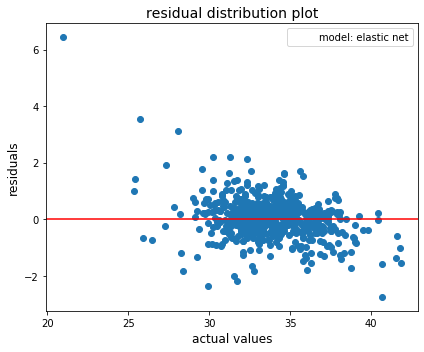

In [18]:
# plot residuals
resid = ypred - ytest.saleprice

plt.rcParams['figure.figsize'] = (6.0, 5.0)
plt.scatter(ytest.saleprice, resid)
plt.axhline(0, linestyle='-', color='r')
plt.title('residual distribution plot',fontsize=14)
plt.xlabel('actual values',fontsize=12)
plt.ylabel('residuals',fontsize=12)
plt.plot([], [], ' ', label="model: elastic net")
plt.legend()
plt.tight_layout()

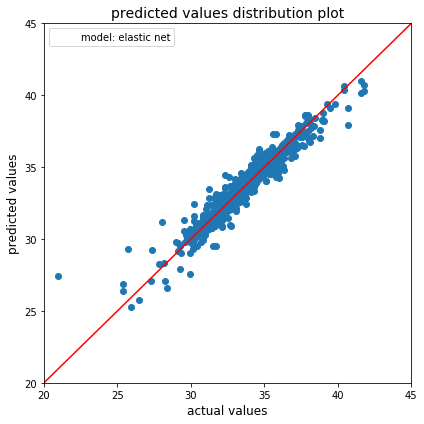

In [19]:
# plot ypred vs ytrue
fig, ax = plt.subplots(figsize=(6.0, 6.0))
ax.scatter(ytest.saleprice, ypred)
ax.set_title('predicted values distribution plot',fontsize=14)
ax.set_xlabel('actual values',fontsize=12)
ax.set_ylabel('predicted values',fontsize=12)
ax.set_xlim(20,45)
ax.set_ylim(20,45)
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="-", c="r")
plt.plot([], [], ' ', label="model: elastic net")
plt.legend()
plt.tight_layout()

## Production model
---

### Feature selection

For an easy to interpret production model, it is necessary to reduce the number of features even further than those selected by the regularised elastic net model (the top model produced 104 non-zero coefficients). This was done using the coefficients obtained from the best model above - cross validation was done on training data to calculate mean validation set MSE and standard errors (SE) for different numbers of coefficients. First, the feature with the highest absolute coefficient was used. Then the feature with the second-highest absolute coefficient was added to the training data, and so on until all 104 features with non-zero coefficients were included in the training data.

The validation set errors are then plotted against number of predictors. MSE appears to stop decreasing significantly from 30 predictors onwards. Using the [one-standard-error-rule](https://www.stat.cmu.edu/~ryantibs/datamining/lectures/19-val2.pdf), the smallest model for which the test MSE is within one SE of the MSE of 30 predictors is 19 (as shown where the red line crosses the black line in the graph) - if two means are within one SE of each other, there is usually no sigificant difference in the means. Therefore, for the purpose of having a simpler and more easily interpretable model, the **top 19 predictors** will be used for the production model. These are:

|Predictor|Coefficient|
|---|---|
|grlivarea 	|0.924321|
|overallqual |	0.441007|
|overallcond |	0.338053|
|age_sold 	|-0.294810|
|lotarea 	|0.256735|
|bsmtfinsf1 |	0.232905|
|yearbuilt 	|0.199919|
|neighborhood_NridgHt| 	0.159834|
|garagearea 	|0.140222|
|bsmtqual 	|0.131523|
|bsmtexposure |	0.125544|
|mszoning_C (all)| 	-0.119000|
|mssubclass_20 	|0.117647|
|neighborhood_StoneBr| 	0.111131|
|kitchenqual 	|0.107051|
|neighborhood_NoRidge |	0.103183|
|exterqual 	|0.096834|
|fireplaces |	0.095645|
|exterior_Brick| 	0.091763|

<font size=2>\* neighborhood_GrnHill was removed as the sample size in the training data was only 2, therefore may not give accurate predictions.</font>

These coefficients are also illustrated in the bar graph below, showing their relative importance/influence on the model. As expected, **square feet** had lots of influence on house price - living area (`grlivarea`) had the highest coefficient: with every 1 unit increase in (scaled) living area in sf, the (transformed) sale price will increase by 0.793 times. Lot area (`lotarea`), basement area (`bsmtfinsf1`), garage area (`garagearea`) were also within the top 19 predictors. The **year** the house was built also affected house price(`yearbuilt`), as did house **condition** (e.g. `overallqual`,, `bsmtqual`, `kitchenqual`) and **location** (being in Northridge Heights, Stone Brook, and Northridge). All the features are positively correlated with saleprice, except for `age_sold` and `mszoning_c (all)`. For `age_sold`, every (scaled) year's increase in the age of a house corresponds to a -0.297 times decrease in (transformed) price. For `mszoning_C (all)`, houses in this zone (commercial) are 0.119 times cheaper (in terms of transformed price) than others.

(If one wants to simplify the model even further, the model can arguably be reduced to just 6 predictors, where there is an obvious 'elbow' in the graph, indicating a less steep decrease in MSE after 6 predictors.)

the model produced 104 non-zero coefficients.


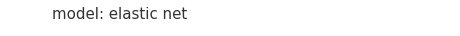

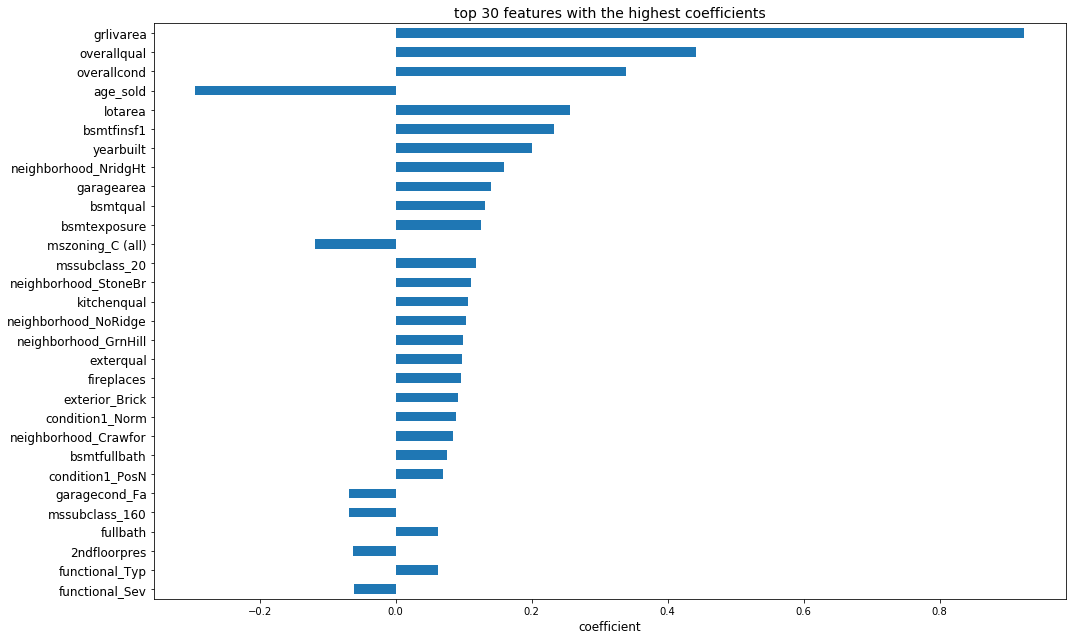

In [20]:
# ---------------------------------------- IDENTIFYING TOP FEATURES ----------------------------------------

# get list of coefficients that are not 0
coef_labels = [col for col in train_dummies.columns if col != 'saleprice'] # column labels
enet_coef = pd.DataFrame(enet_mod.coef_, index = coef_labels)              # get coefficients from best model
enet_coef = enet_coef[enet_coef[0] != 0]                                   # get non-zero coefficients
print(f'the model produced {enet_coef.shape[0]} non-zero coefficients.')

# sort by absolute values
enet_coef = enet_coef.reindex(enet_coef[0].abs().sort_values(ascending=True).index)

# plot title
plt.figure(figsize=(8, 0.3))
plt.text(x = 0.1,                              
         y = 0.9,                             
         s = 'model: elastic net', 
         ha = 'left',                        
         va = 'center',                       
         size = 15,                            
         alpha = 0.8)                         
plt.axis('off')

# plot top 30 coefficients
enet_coef.tail(30).plot.barh(figsize=(15,9), legend = None)
plt.title('top 30 features with the highest coefficients',fontsize=14)
plt.xlabel('coefficient', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

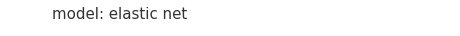

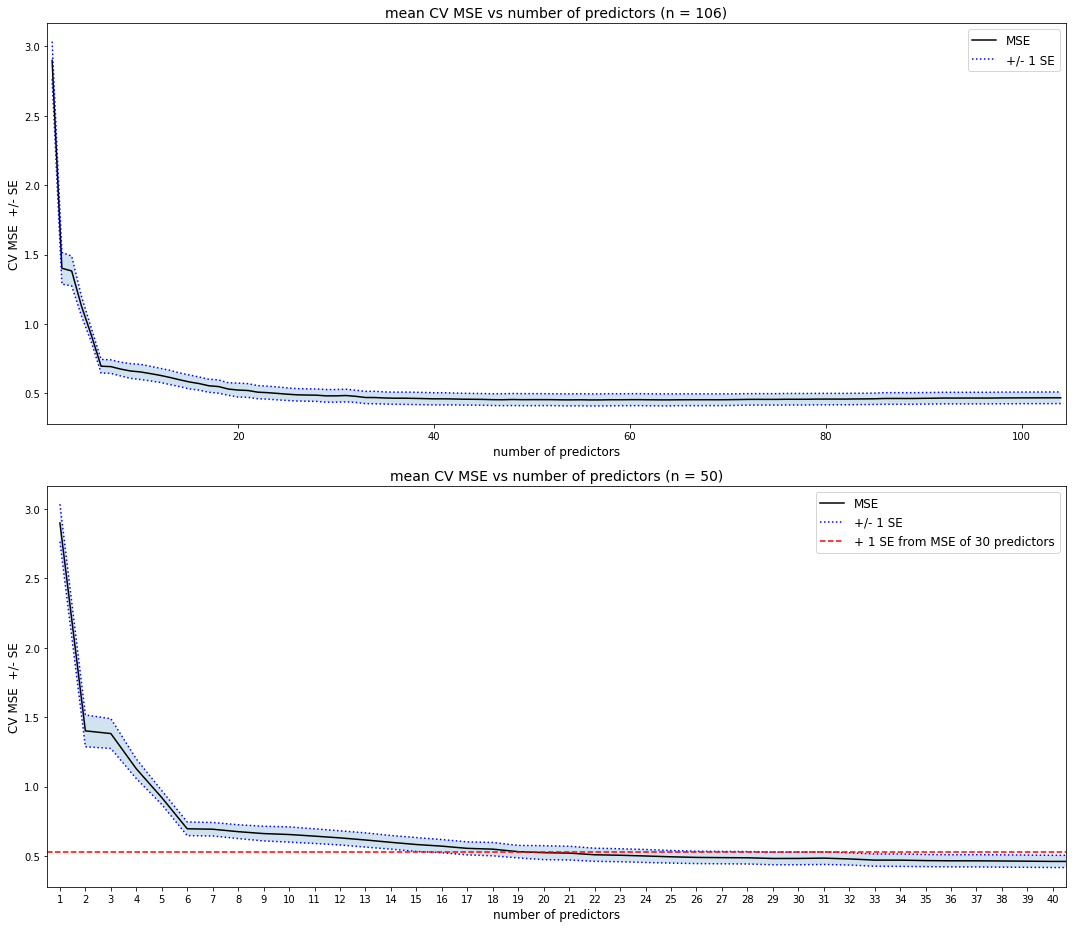

In [21]:
# ------------------ EVALUATING MODEL PERFORMANCE (USING CV) BASED ON NO. OF FEATURES --------------------

# put the test data into a dataframe so they can be sliced
xtrain_df = pd.DataFrame(xtrain_scaled, columns = coef_labels)
    
# for each number of predictors in the 104 non-zero predictors, compute validation set error (MSE) and SE
# starting from the predictor with the highest coefficient
n_predictors = 104
mse_mean = []
mse_se = []
for n in range(1,n_predictors+1):
    predictors = enet_coef.index[-n:]  # coefficients are sorted by absolute values, highest at bottom
    xtrain_sliced = xtrain_df[predictors]   # slice out just that predictor from xtest_scaled
    # get validation set MSE and MSE variance
    cv_scores = -cross_val_score(lasso_mod, xtrain_sliced, ytrain, scoring = 'neg_mean_squared_error', cv = 5)
    mse_mean.append(cv_scores.mean())
    mse_se.append(cv_scores.std()/np.sqrt(5))

    
# ----------------------------------------- PLOT TITLE ---------------------------------------------------
plt.figure(figsize=(8, 0.3))
plt.text(x = 0.1,                              
         y = 0.9,                             
         s = 'model: elastic net', 
         ha = 'left',                        
         va = 'center',                       
         size = 15,                            
         alpha = 0.8)                         
plt.axis('off')

# ------------------------- PLOT VALIDATION SET ERROR AGAINST NO. PREDICTORS -----------------------------
fig, ax = plt.subplots(ncols = 1, nrows = 2, figsize=(15,13))

# PLOT WITH ALL PREDICTORS

ax[0].plot(np.arange(1,n_predictors+1,1), mse_mean, 'k', label = 'MSE')
# plot error lines showing +/- SE of the MSE
ax[0].plot(np.arange(1,n_predictors+1,1),[a+b for a, b in zip(mse_mean,mse_se)], 'b:',
        label='+/- 1 SE')
ax[0].plot(np.arange(1,n_predictors+1,1),[a-b for a, b, in zip(mse_mean,mse_se)], 'b:')
# set fill color between error lines
ax[0].fill_between(np.arange(1,n_predictors+1,1), [a+b for a, b in zip(mse_mean,mse_se)],
                                   [a-b for a, b in zip(mse_mean,mse_se)], alpha=0.2)
ax[0].set_title('mean CV MSE vs number of predictors (n = 106)', fontsize=14)
ax[0].set_ylabel('CV MSE  +/- SE', fontsize = 12)
ax[0].set_xlabel('number of predictors', fontsize = 12)
ax[0].set_xlim(0.5, n_predictors + 0.5)
ax[0].legend(loc = 'upper right',  prop={'size': 12})

# ZOOMED-IN PLOT WITH 40 PREDICTORS

ax[1].plot(np.arange(1,n_predictors+1,1), mse_mean, 'k', label = 'MSE')
# plot error lines showing +/- SE of the MSE
ax[1].plot(np.arange(1,n_predictors+1,1),[a+b for a, b in zip(mse_mean,mse_se)], 'b:',
        label='+/- 1 SE')
ax[1].plot(np.arange(1,n_predictors+1,1),[a-b for a, b, in zip(mse_mean,mse_se)], 'b:')
# set fill color between error lines
ax[1].fill_between(np.arange(1,n_predictors+1,1), [a+b for a, b in zip(mse_mean,mse_se)],\
                                   [a-b for a, b in zip(mse_mean,mse_se)], alpha=0.2)
# there does not seem to be significant declines in MSE beyond 30 predictors
# plot horizontal line for the MSE of 30 predictors, + 1 SE
ax[1].axhline(mse_se[29]+mse_mean[29], linestyle='--', color='r',label = '+ 1 SE from MSE of 30 predictors')
ax[1].set_title('mean CV MSE vs number of predictors (n = 50)', fontsize=14)
ax[1].set_ylabel('CV MSE  +/- SE', fontsize = 12)
ax[1].set_xlabel('number of predictors', fontsize = 12)
ax[1].set_xticks(np.arange(1,41,1))
ax[1].set_xlim(0.5, 40 + 0.5)
ax[1].legend(loc = 'upper right',  prop={'size': 12})

plt.tight_layout()

In [22]:
# viewing top 19 features and their coefficients (highest at the bottom, sorted by absolute value)
enet_coef.tail(19)

# as neighborhood_GrnHill has very few samples in the original data (see below), it will not be used
# viewing top 20 features to include the next top predictor
enet_coef.tail(20)

,0
exterior_Brick,0.091763
fireplaces,0.095645
exterqual,0.096834
neighborhood_GrnHill,0.099211
neighborhood_NoRidge,0.103183
kitchenqual,0.107051
neighborhood_StoneBr,0.111131
mssubclass_20,0.117647
mszoning_C (all),-0.119000
bsmtexposure,0.125544


In [23]:
# checking sample size for categorical coefficients in the original train df
print(train.neighborhood.value_counts())   # NridgeHt, StoneBr, and NoRidge look okay, but GrnHill only has 2
print(train.mszoning.value_counts())       # mszoning_c is a bit low 
print(train.mssubclass.value_counts())     # mssubclass 20 looks okay

NAmes      309
CollgCr    180
OldTown    163
Edwards    141
Somerst    130
NridgHt    122
Gilbert    116
Sawyer     111
NWAmes      87
SawyerW     87
Mitchel     82
BrkSide     76
Crawfor     71
IDOTRR      69
NoRidge     48
Timber      48
StoneBr     38
SWISU       32
ClearCr     25
MeadowV     24
Blmngtn     22
BrDale      19
NPkVill     17
Veenker     17
Blueste      6
Greens       3
GrnHill      2
Landmrk      1
Name: neighborhood, dtype: int64
RL         1593
RM          316
FV          101
C (all)      19
RH           14
A (agr)       2
I (all)       1
Name: mszoning, dtype: int64
20     767
60     393
50     197
120    132
30     101
70      90
160     88
80      86
90      75
190     46
85      28
75      16
180     11
45      11
40       4
150      1
Name: mssubclass, dtype: int64


### Performance of production model

The scores for the reduced elastic net model using these 19 predictors are:

| Model              	| R2      	| RMSE    	|
|-------	            |---------	|---------	|
| reduced  - train  	| 0.91200 	| 0.73577  	|
| reduced - test    	| 0.90493 	| 0.77700 	|
| full model - train 	| 0.91808  	| 0.71047  	|
| full mode - test  	| 0.91925 	| 0.71612 	|

Compared to the performance of the full model (with all 104 predictors), the reduced model still gave a relatively good score (with low RMSE and an R<sup>2</sup> score of 0.904 - or being able to account for 90.4% of the variations in sale price) while improving interpretability.

In [24]:
# get list of top 19 predictors
predictors = list(enet_coef.index[-20:])

# remove greenhill, for which predictions may not be accurate due to low sample size
predictors.remove('neighborhood_GrnHill')
len(predictors)

19

In [25]:
# ------------------ FIT MODEL TO TEST DATA WITH FEATURES SELECTED FROM ABOVE ------------------

# put the data into a dataframe so they can be sliced
xtrain_df = pd.DataFrame(xtrain_scaled, columns = coef_labels)
xtest_df = pd.DataFrame(xtest_scaled, columns = coef_labels)

# slice out selected predictors
xtrain_slice = xtrain_df[predictors]
xtest_slice = xtest_df[predictors]

# CV training score
print(crossval(enet, xtrain_slice, ytrain))

# fit model to train data
enet_mod = enet.fit(xtrain_slice, ytrain)

# predict on test data
ypred = enet_mod.predict(xtest_slice)

# get test scores
print('enet test R2: ', enet_mod.score(xtest_slice, ytest))
print('enet test RMSE: ', rmse(ytest, ypred))

('mean CV R2:', 0.9120030443578211, 'mean CV RMSE:', 0.735776450019223, 'CV R2 variance:', 0.00017602488748328138, 'CV RMSE variance:', 0.008388881749979631)
enet test R2:  0.9049374004551605
enet test RMSE:  0.7770058923951956


## Conclusion and Recommendations
---

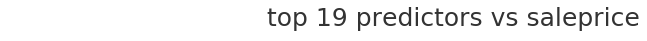

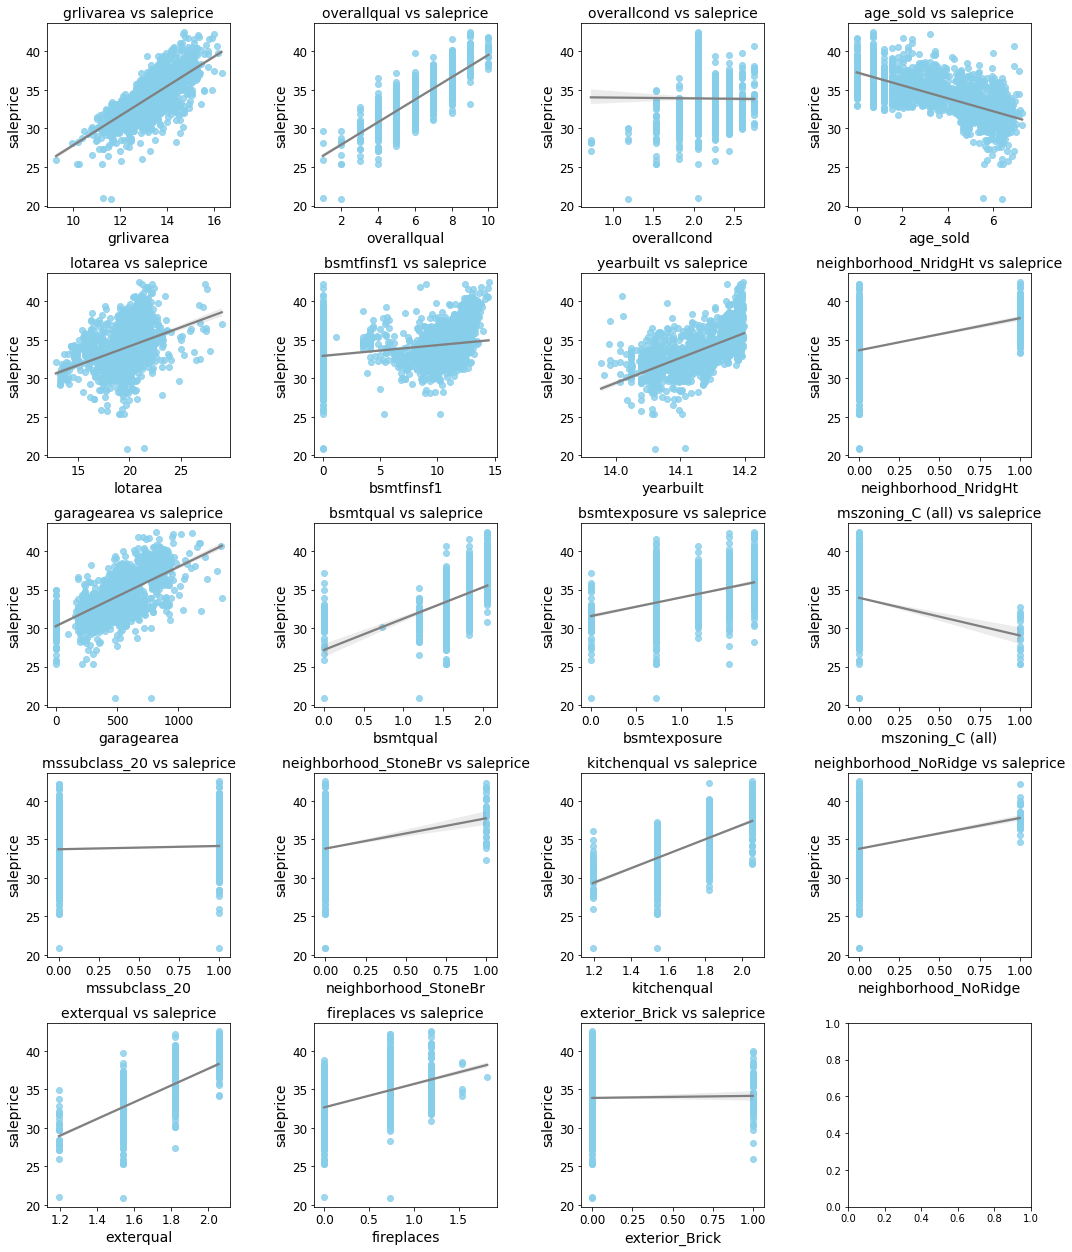

In [26]:
# function for scatterplot subplots
def subplot_scatter(dataframe, list_of_columns):
    nrows = int(np.ceil(len(list_of_columns)/4)) 
    fig, ax = plt.subplots(nrows=nrows, ncols=4,figsize=(15, nrows*3.5)) 
    ax = ax.ravel() 
    for i, column in enumerate(list_of_columns): 
        sns.regplot(y=dataframe.saleprice, x=dataframe[column],ax=ax[i], \
                    scatter_kws={'facecolors':'skyblue','edgecolor':'skyblue'},
                    line_kws = {'color':'grey'})
        ax[i].set_title(f'{column} vs saleprice',fontsize=14)  
        ax[i].tick_params(labelsize=12)
        ax[i].set_xlabel(column, fontsize=14)
        ax[i].set_ylabel('saleprice', fontsize=14)
    plt.tight_layout()
 
# scatterplots for top 19 predictors
plt.figure(figsize=(8, 0.3))
plt.text(x = 1,                              
         y = 0.9,                             
         s = 'top 19 predictors vs saleprice', 
         ha = 'center',                        
         va = 'center',                       
         size = 25,                            
         alpha = 0.8)                         
plt.axis('off')

subplot_scatter(train_dummies, predictors[::-1])

An elastic net regression model had the best predictive performance on housing sale price in Ames USA, and outperformed the other linear models tested. As a regularised regression method, it was able to reveal which features affect sale price the most. 

Square feet area, condition, age, and the location of the house are the most important determinant factors of how much a house sells for (see figure above). As a buyer with a specific budget, the model would allow them to find out what features they would be able to afford, e.g. how big a house they can buy in Northridge with a \\$50,000 budget. Houses in Northridge Heights, Stone Brook, and Northridge all had higher prices compared to other neighbourhoods, therefore those looking to invest could consider those areas, whereas houses in the commercial zone and and 2 storey houses (built 1946 and newer) should be avoided.

Conversely, people looking to sell their house would be able to use the model to get an estimate of how much they would be able to sell their house for, given the features of the house. If one is looking to sell their house, they should do it sooner rather than later, as the age of the house is the biggest contributing factor to the decrease in value. Having a garage in bad condition also negatively affect value, as does having a second floor to the house. And unsurprisingly, if the house is severely damaged, its value drops. As such, those looking to increase the value of their home could consider (in order of how much each feature affect price):
- repainting the interior and exterior of the house to improve overall material and finish quality
- renovating the kitchen to improve kitchen quality, e.g. by retiling and adding modern appliances
- adding a fireplace (if not already present)
- renovating the garage if it is in bad condition
- renovating the house if it had been severely damaged

However, as the model was developed using data on houses sold between 2006 - 2010 in Ames, USA, it may have limited applicabilities. Firstly, it captures only a small time frame of four years (also with some missing months in each year). This is not enough to capture any annual patterns in sale price that could arise as a result of external factors, such as policy changes, the current economomy and whether or not it is a recession year. It is also unknown whether or not the sale prices had been adjusted for inflation within those years, which would have been a source of variation in saleprice otherwise. As it is currently 2019, house prices may have changed due to one or more of these factors. Therefore this model may not be accurate when applied to present-day data. 

Secondly, there may also be other factors affecting house price, since the model only accounted for 90.4% of the variations in sale price. The remaining 9.6% could be due to factors related to area desirability (i.e. location). In the current dataset, only neighborhoods and proximity to roads are included under this category. In reality, factors like presence of schools, hospitals, malls, beaches, and the CBD are some examples of other factors that are also likely to affect house price.

Lastly, the model is specific to houses in Ames and may not be as accurate when applied to data from another city or country. Variations in cultures mean people in different countries look for different things in a house, which would in turn affect sale price. For example, having a fireplace in a house in Singapore (or anywhere in the tropics) is unlikely to bring the value of the house up, as few people in these places want a fireplace in their house. To make the model more universal, one would need to remove certain Ames- or USA- specific features, such as garage presence, basement presence, and the Ames neighbourhoods. These could be converted to or included in more universal features, such as total square footage.

Therefore, to improve the applicability of the model, one can consider adding in more data from a wider time frame, from different locations, and on more universal features. Another improvement would be to analyse the features more closely to see the extent to which they may affect price before there is diminishing returns, e.g. how many fireplaces is economical to add to increase home value, before there are too many fireplaces. Lastly, a lasso model is good for feature selection but is less interpretable than an ordinary linear model, due to the scaling of features. It is difficult for someone to tell immediately, for instance, how much the value of a house would be reduced by with every 1 year increase in age. Therefore, another improvement may be to find a model that performs just as well but is also easy to interprete, so that it will be more readily understood and accepted by the general public.

In reality, house price may be difficult to predict as it is also affected by buyers' psychology, the economic climate, and other factors not included in the present dataset. There will never be a perfect model; the aim of this model is therefore not to give a perfect prediction, but act as a guideline to inform decisions.

## Kaggle Submission
---

The Kaggle score (RMSE) for the production model was **27554**.

### Import preprocessed test data

All the transformations on features have been done in the preprocessing notebook (#2).

In [27]:
test = pd.read_csv('data/test_cleaned.csv')

# remove unnamed and index columns
test = test.iloc[:, 2:]

# convert mssubclass to string again since it got converted back to int on import
test['mssubclass'] = test['mssubclass'].astype(str)

test.head(5)

,id,mssubclass,mszoning,lotfrontage,lotarea,lotshape,landcontour,lotconfig,landslope,neighborhood,condition1,bldgtype,housestyle,overallqual,overallcond,yearbuilt,roofstyle,masvnrtype,masvnrarea,exterqual,foundation,bsmtqual,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtunfsf,heatingqc,grlivarea,bsmtfullbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,functional,fireplaces,fireplacequ,garagetype,garagefinish,garagearea,garagecond,wooddecksf,mosold,yrsold,porchpres,poolpres,garagepres,fireplacepres,masvnrpres,bsmtpres,shedpres,exterior,age_sold,remodelled,2ndfloorpres,bighouse
0,2658,190,RM,5.942124,19.519507,0.000000,Lvl,Inside,flat,OldTown,Norm,2fmCon,2Story,6,2.602594,14.039411,Gable,None,0.000000,1.540963,Stone,1.194318,0.730463,Unf,0.000000,12.181217,1.820334,14.068550,0.000000,2,0.000000,1.820334,1.194318,1.194318,Typ,0.000000,0,Detchd,Unf,440,Po,0.000000,1.820334,2006,1,0,1,0,0,1,0,Aesbestos,6.574447,1.0,1,0.0
1,2718,90,RL,6.098626,19.737687,0.730463,Lvl,Inside,flat,Sawyer,Norm,Duplex,1Story,5,1.820334,14.146717,Gable,None,0.000000,1.540963,CBlock,1.820334,0.730463,Unf,0.000000,14.130899,1.540963,14.130899,0.000000,2,0.000000,2.259674,1.194318,1.540963,Typ,0.000000,0,Attchd,Fin,580,TA,7.749778,2.602594,2006,0,0,1,0,0,1,0,Wood,4.437269,0.0,0,0.0
2,2414,60,RL,5.622899,22.099183,0.730463,Lvl,Inside,flat,Gilbert,Norm,1Fam,2Story,7,2.055642,14.192207,Gable,None,0.000000,1.820334,PConc,1.820334,1.540963,GLQ,10.534293,6.654950,2.055642,13.294780,0.730463,2,0.730463,1.540963,0.730463,1.820334,Typ,0.730463,4,Attchd,RFn,426,TA,6.654950,2.750250,2006,1,0,1,1,0,1,0,Vinyl,0.000000,0.0,1,0.0
3,1989,30,RM,5.684507,19.244223,0.000000,Lvl,Inside,flat,OldTown,Norm,1Fam,1Story,5,2.259674,14.060479,Gable,None,0.000000,1.820334,CBlock,1.540963,0.730463,Unf,0.000000,12.034009,1.540963,12.034009,0.000000,1,0.000000,1.194318,0.730463,1.540963,Typ,0.000000,0,Detchd,Unf,480,TA,0.000000,2.440268,2007,1,0,1,0,0,1,0,Wood,6.314735,1.0,0,0.0
4,625,20,RL,6.085993,19.670808,0.730463,Lvl,Inside,flat,NAmes,Norm,1Fam,1Story,6,2.055642,14.124553,Gable,BrkFace,8.576545,1.540963,CBlock,1.820334,0.730463,BLQ,10.779829,11.456001,1.820334,13.084596,0.730463,1,0.730463,1.540963,0.730463,1.540963,Typ,1.194318,4,Attchd,RFn,514,TA,0.000000,2.440268,2009,1,0,1,1,1,1,0,Wood,5.210789,0.0,0,0.0


### One-hot-encode test data

In [28]:
test_dummies = pd.get_dummies(test)

### Scale test data

In [29]:
# slice out selected predictors from the test df
test_sliced = test_dummies[predictors]
xtrain_sliced = xtrain[predictors]

# transforming only
scaler = StandardScaler()
scaler.fit(xtrain_sliced)
test_scaled = scaler.transform(test_sliced)

### Fit model and predict using test data

This uses the [model from above section](#Performance-of-production-model) that had been fitted to the training data with the top 17 predictors.

In [30]:
# predict on test data
ypred = enet_mod.predict(test_scaled)

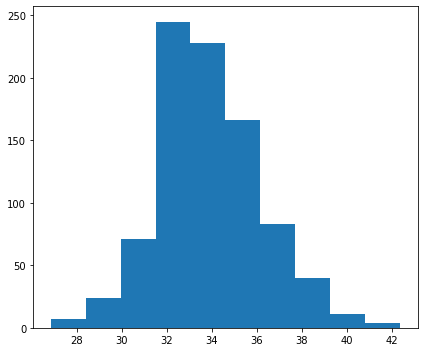

In [31]:
# sanity check - plot histogram of ypred (transformed)
plt.hist(ypred)
plt.tight_layout()

### Convert and export predicted test data

The production model was tuned and fitted with the transformations done to `saleprice`:
1. Box-Cox transformation ($\lambda$ = 0.15)

These will need to be reversed with the `saleprice` predicted using the final model.

The [Box-Cox transformation used by scipy](https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.special.boxcox1p.html) is:<br>
<font size=5>$y = \frac{(1+x)^\lambda - 1}{\lambda}$</font>, where $\lambda = 0.15$

In [32]:
ypred_untransform = (ypred * 0.15 + 1)**(1/0.15) - 1

# check that there're 879 prediction rows
export = pd.DataFrame({'Id': test.id, 'SalePrice': ypred_untransform})
print(export.shape)
export.to_csv('data/submissions_20191010.csv', index =False) 

(879, 2)


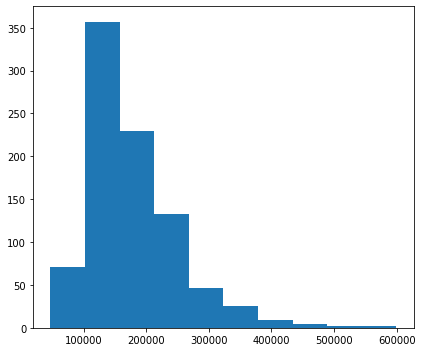

In [33]:
# sanity check - plot histogram of ypred (final)
plt.hist(ypred_untransform)
plt.tight_layout()